In [3]:
import seaborn as sb

In [4]:
# Code from https://github.com/kastnerkyle/kastnerkyle.github.io/blob/master/posts/robust-matrix-decomposition/robust-matrix-decomposition.ipynb
# Based on paper "The Augmented Lagrange Multiplier Method for Exact Recovery of Corrupted Low-Rank Matrices" by Yi Ma

import numpy as np
from numpy.linalg import norm, svd

def inexact_augmented_lagrange_multiplier(X, lmbda=.01, tol=1e-3,
                                          maxiter=100, verbose=True):
    """
    Inexact Augmented Lagrange Multiplier
    """
    Y = X
    norm_two = norm(Y.ravel(), 2)
    norm_inf = norm(Y.ravel(), np.inf) / lmbda
    dual_norm = np.max([norm_two, norm_inf])
    Y = Y / dual_norm
    A = np.zeros(Y.shape)
    E = np.zeros(Y.shape)
    dnorm = norm(X, 'fro')
    mu = 1.25 / norm_two
    rho = 1.5
    sv = 10.
    n = Y.shape[0]
    itr = 0
    while True:
        Eraw = X - A + (1 / mu) * Y
        Eupdate = np.maximum(Eraw - lmbda / mu, 0) + np.minimum(Eraw + lmbda / mu, 0)
        U, S, V = svd(X - Eupdate + (1 / mu) * Y, full_matrices=False)
        svp = (S > 1 / mu).shape[0]
        if svp < sv:
            sv = np.min([svp + 1, n])
        else:
            sv = np.min([svp + round(.05 * n), n])
        Aupdate = np.dot(np.dot(U[:, :svp], np.diag(S[:svp] - 1 / mu)), V[:svp, :])
        A = Aupdate
        E = Eupdate
        Z = X - A - E
        Y = Y + mu * Z
        mu = np.min([mu * rho, mu * 1e7])
        itr += 1
        if ((norm(Z, 'fro') / dnorm) < tol) or (itr >= maxiter):
            break
    if verbose:
        print("Finished at iteration %d" % (itr))  
    return A, E

In [5]:
import L_S_decomp as ls

A, B, C = ls.l_s(10, 10, 2, 2)

In [6]:
L0, S0 = inexact_augmented_lagrange_multiplier(A)

Finished at iteration 22


In [7]:
np.linalg.norm(B - L0, ord="fro")/np.linalg.norm(B, ord="fro")

1.0000436073166767

In [8]:
np.linalg.norm(C - S0, ord="fro")/np.linalg.norm(C, ord="fro")

7.471161076528108

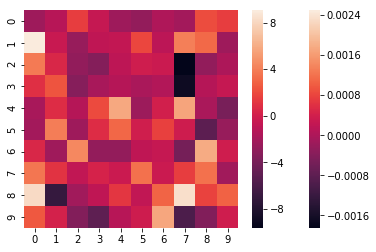

In [15]:
sb.heatmap(L0)
sb.heatmap(B)